In [1]:
! pip install stable-baselines3[extra]
! pip install yfinance

     |████████████████████████████████| 153kB 12.1MB/s 
     |████████████████████████████████| 6.3MB 13.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=cf4786b3da3661e9d027f6dd955a9fd5d7263a47e69936d9070ebc733476e1ec
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3721    0  3721    0     0   7752      0 --:--:-- --:--:-- --:--:--  7752
100  503k  100  503k    0     0   381k      0  0:00:01  0:00:01 --:--:--  828k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3729    0  3729    0     0   8250      0 --:--:-- --:--:-- --:--:--  8231
100  406k  100  406k    0     0   336k      0  0:00:01  0:00:01 --:--:--  336k


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import yfinance as yf

In [4]:
import gym
from gym import spaces

# Data loading

In [5]:
INIT_NET_WORTH = 10000
WINDOW = 10
ROLLING = 126

In [6]:
TICKER = 'SPY'

if TICKER == 'COSINE':
    df = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    df = yf.download(TICKER, start="2000-01-01", end="2011-01-01")

[*********************100%***********************]  1 of 1 completed


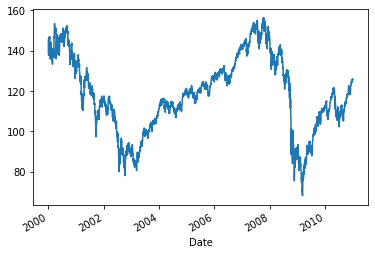

In [7]:
df['Close'].plot()

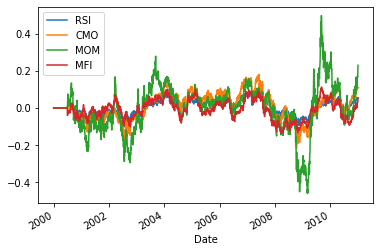

In [8]:
pd.DataFrame(
            {
                'RSI': ((talib.RSI(df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, index = df.index
        ).plot()

# Environment

In [9]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [10]:
class StockTradingEnv(gym.Env):

    def __init__(self, df, init_account_balance, window_shape, random_start = False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance  
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        # self.signal_features = self.df[['Open', 'Close', 'High', 'Low']].pct_change().fillna(0.0).iloc[self.start:self.end] 
        # self.signal_features = self.df[['Close']].pct_change().fillna(0.0).iloc[self.start:self.end]   

        self.signal_features = pd.DataFrame(
            {
                'RSI': ((talib.RSI(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': self.df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, 
            index = self.df.index).iloc[self.start:self.end]
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step-self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.net_worth <= 0) or (self.current_step >= (len(self.df) - self.window_shape)):
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = random.uniform(
              self.df.iloc[self.current_step]["Open"],
              self.df.iloc[self.current_step]["Close"]
          )

        if not self.in_position:
            if action == 1: # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else: # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1: # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else: # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0                

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance
        }

In [11]:
N_TIME_STEPS = len(df) - WINDOW
LR = 0.001
RANDOM_SEED = 11111

In [12]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
env_train_viz = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 379      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -1.8e-05 |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | 1.64e+04 |
|    value_loss         | 6.69e+08 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 396      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 9.18e-06 |
|    learning_rate      | 0.001    |
|    n_updates          | 199      |
|    policy_loss        | 1.28e+04 |
|    value_loss     

# In-sample evaluation

In [13]:
def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': []
    }

    for i in range(len(df) - WINDOW):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action)
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

In [14]:
history, actions_over_time = evaluate_agent(env_train_viz, df, model)

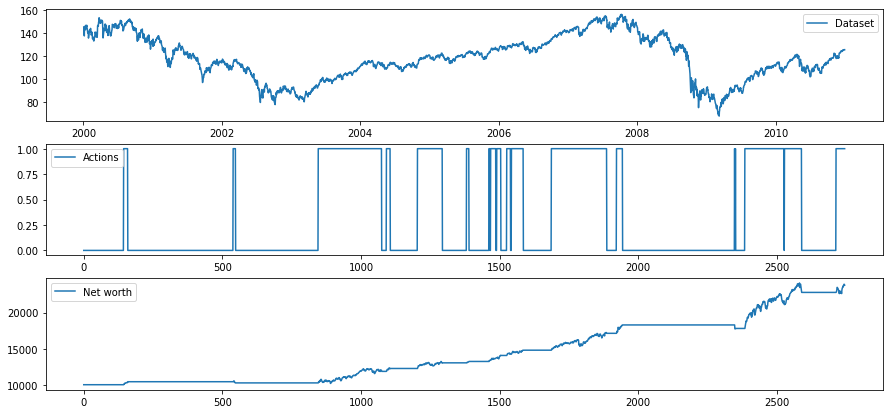

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df['Close'], label = 'Dataset')
ax2.plot(actions_over_time.flatten(), label = 'Actions')
ax3.plot(np.array(history['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Evaluation single holdout out-of-sample

In [16]:
if TICKER == 'COSINE':
    df_test = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    df_test = yf.download(TICKER, start="2011-01-01", end="2021-07-01")

[*********************100%***********************]  1 of 1 completed


In [17]:
env_test = DummyVecEnv([lambda: StockTradingEnv(df_test, INIT_NET_WORTH, WINDOW)])

In [18]:
history_test, actions_over_time_test = evaluate_agent(env_test, df_test, model)

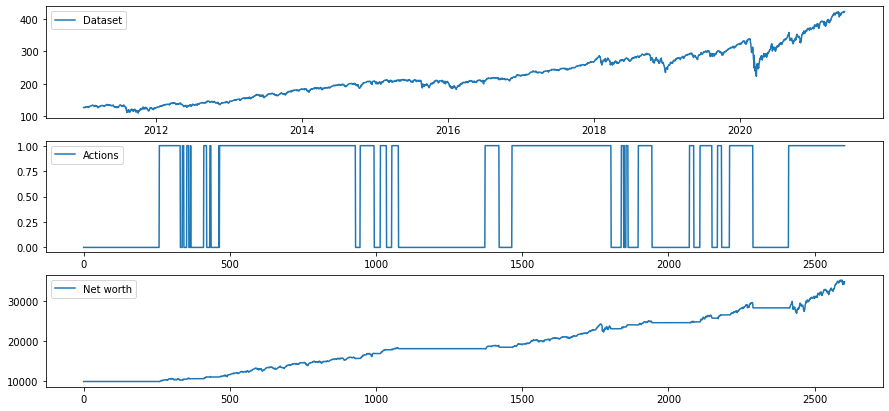

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df_test['Close'], label = 'Dataset')
ax2.plot(actions_over_time_test.flatten(), label = 'Actions')
ax3.plot(np.array(history_test['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Metrics and point evaluation
https://quantdare.com/probabilistic-sharpe-ratio/

In [20]:
from scipy import stats as scipy_stats

In [21]:
train_returns = pd.DataFrame(history['net_worth']).pct_change().fillna(0.0).values
test_returns = pd.DataFrame(history_test['net_worth']).pct_change().fillna(0.0).values
train_benchmark = df['Close'].pct_change().fillna(0.0).values
test_benchmark = df_test['Close'].pct_change().fillna(0.0).values

### Sharpe ratio variations

In [22]:
def estimated_sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

def annualized_sharpe_ratio(returns, periods = 252):
    return np.mean(returns) / np.std(returns) * np.sqrt(periods)

def estimated_sharpe_ratio_stdev(returns):
    # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    _returns = pd.DataFrame(returns)
    n = len(_returns)
    skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    sr = estimated_sharpe_ratio(_returns)
    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))
    return sr_std

def probabilistic_sharpe_ratio(returns, sr_benchmark=0.0):
    sr = estimated_sharpe_ratio(returns)
    sr_std = estimated_sharpe_ratio_stdev(returns)
    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)
    return psr[0]

In [23]:
annualized_sharpe_ratio(train_benchmark), annualized_sharpe_ratio(test_benchmark)

(0.05017004802099098, 0.7593187881520735)

In [24]:
annualized_sharpe_ratio(train_returns), annualized_sharpe_ratio(test_returns)

(1.3440767682827262, 1.6497439069684323)

In [25]:
probabilistic_sharpe_ratio(train_returns, 0.0), probabilistic_sharpe_ratio(test_returns, 0.0)

(0.9999874500156991, 0.9999998220998808)

### Beating the benchmark

In [26]:
def information_ratio(returns, benchmark):
    diff = returns - benchmark
    return np.mean(diff) / np.std(diff)

In [27]:
information_ratio(train_returns, train_benchmark), information_ratio(test_returns, test_benchmark)

(0.019362053135726906, -0.002197816950957475)

In [28]:
probabilistic_sharpe_ratio(
    train_returns, estimated_sharpe_ratio(train_benchmark)
    ), probabilistic_sharpe_ratio(
    test_returns, estimated_sharpe_ratio(test_benchmark)
   )

(0.9999751046898073, 0.9970011022077093)

# Probabilistic evaluation: combinatorial cross-validation

In [29]:
from sklearn.model_selection import BaseCrossValidator
from itertools import combinations 
import tqdm

In [30]:
class CombinatorialCV(BaseCrossValidator):

    def __init__(self, X, N, k):
        self.X = X
        self.N = N
        self.k = k

    def generate_eras(self):
        # assuming exact division, we will cut-off small piece of time series
        # in the very beginning
        return np.array(sum([
                    [i] * (len(self.X) // self.N) for i in range(self.N)
                    ], []
                   )
        )
        
    def split(self, X=None, y=None, groups=None):
        # removing first m items from time series
        eras = self.generate_eras()
        len_diff = abs(len(self.X) - len(eras))
        comb = list(combinations(range(self.N), self.N-self.k))
        all_splits = range(self.N)

        for combination in comb:
            train_indices, test_indices = [], []
            for c in combination:
                indices_train = list(np.where(eras == c)[0])
                train_indices.extend(indices_train)
            for t in list(set(all_splits) - set(combination)):
                indices_test = list(np.where(eras == t)[0])
                test_indices.extend(indices_test)
            yield(train_indices, test_indices)  
              
    def get_n_splits(self):
        comb = combinations(range(self.N), self.N-self.k)
        return len(list(comb))

In [31]:
if TICKER == 'COSINE':
    full_df = pd.DataFrame({
        'High': np.sin(np.arange(5000)/100.0) + np.random.normal(2, 0.02, size = (5000, )),
        'Open': np.sin(np.arange(5000)/100.0) + np.random.normal(2, 0.02, size = (5000, )),
        'Close': np.sin(np.arange(5000)/100.0) + np.random.normal(2, 0.02, size = (5000, )),
        'Low': np.sin(np.arange(5000)/100.0) + np.random.normal(2, 0.02, size = (5000, )),
        'Volume': np.abs(np.sin(np.arange(5000)/100.0)),
      }
      )
else:
    full_df = yf.download(TICKER, start="2000-01-01", end="2021-07-01")

[*********************100%***********************]  1 of 1 completed


In [32]:
N, k = 6, 3
cv = CombinatorialCV(full_df, N, k)
cv.get_n_splits()

20

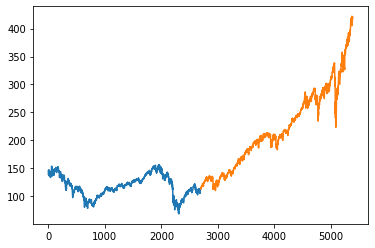

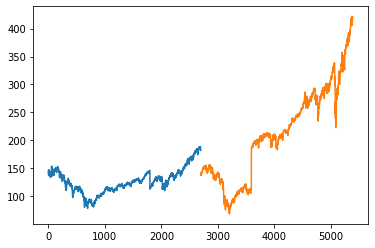

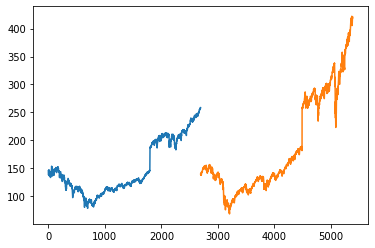

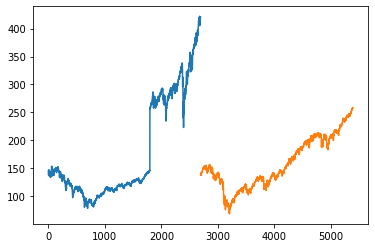

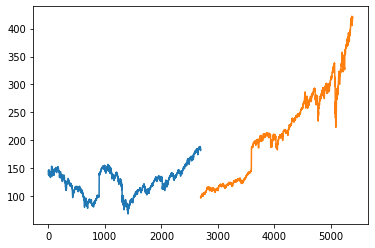

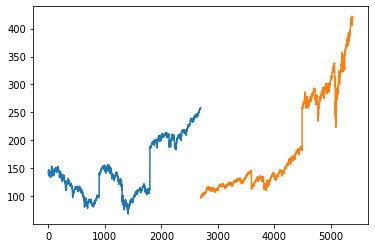

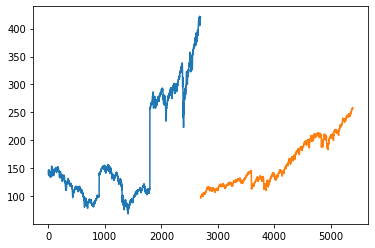

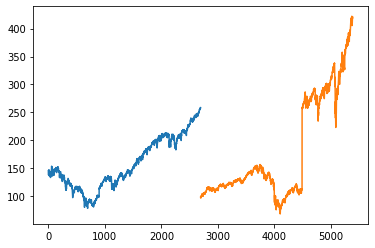

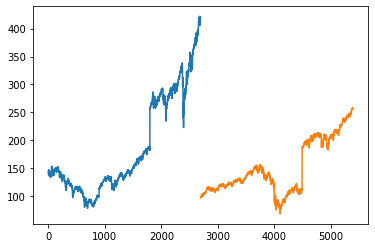

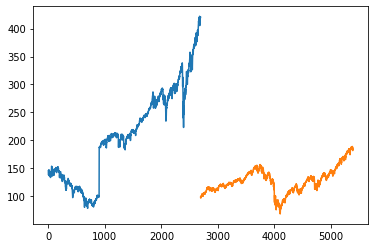

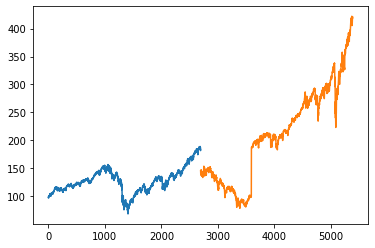

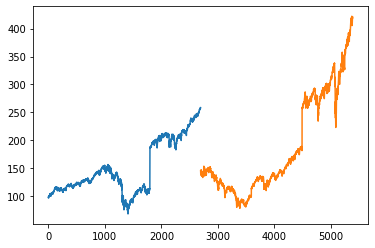

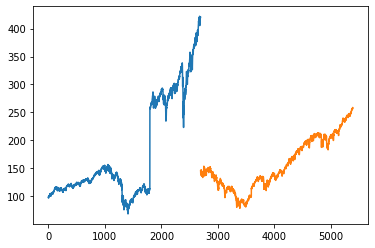

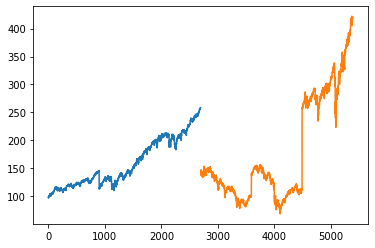

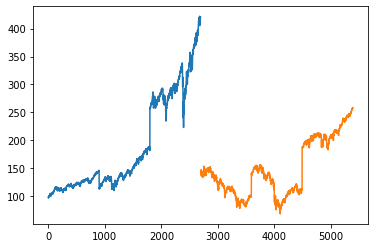

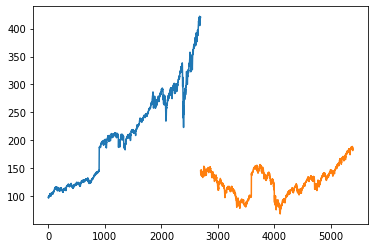

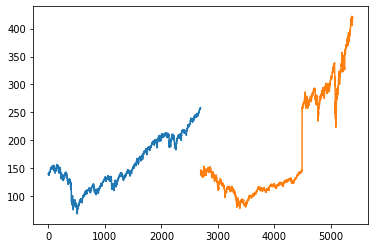

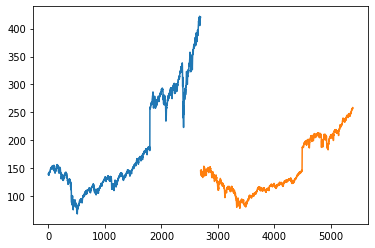

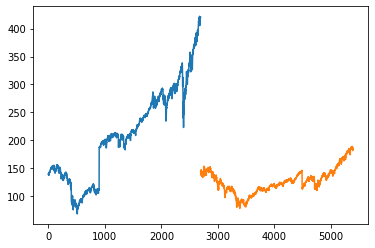

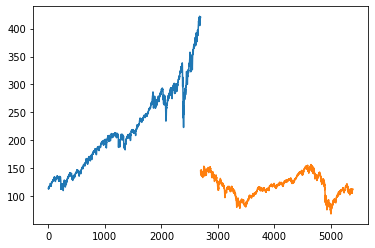

In [33]:
for train_ids, test_ids in cv.split():
    X_train, X_test = full_df.iloc[train_ids], full_df.iloc[test_ids]
    plt.figure()
    plt.plot(range(len(X_train)), X_train['Close'])
    plt.plot(range(len(X_train), len(X_train)+len(X_test)), X_test['Close'])
    plt.show()

In [34]:
train_results, test_results = {}, {}

for e, (train_ids, test_ids) in tqdm.tqdm(enumerate(cv.split())):

    X_train, X_test = full_df.iloc[train_ids], full_df.iloc[test_ids]
    env_train_cv = DummyVecEnv([lambda: StockTradingEnv(X_train, INIT_NET_WORTH, WINDOW)])
    env_train_cv_viz = DummyVecEnv([lambda: StockTradingEnv(X_train, INIT_NET_WORTH, WINDOW)])
    env_test_cv = DummyVecEnv([lambda: StockTradingEnv(X_test, INIT_NET_WORTH, WINDOW)])

    model_cv = A2C('MlpPolicy', env_train_cv, verbose=0, learning_rate=LR, seed=RANDOM_SEED)
    model_cv.learn(total_timesteps=N_TIME_STEPS)

    history_train_cv, actions_over_time_train_cv = evaluate_agent(env_train_cv_viz, X_train, model_cv)
    history_test_cv, actions_over_time_test_cv = evaluate_agent(env_test_cv, X_test, model_cv)

    train_results[e] = {
            'history': history_train_cv, 
            'benchmark': X_train['Close'],
            'actions_over_time': actions_over_time_train_cv
    }
                        
    test_results[e] = {
            'history': history_test_cv, 
            'benchmark': X_test['Close'],
            'actions_over_time': actions_over_time_test_cv
    }


20it [04:22, 13.10s/it]


In [35]:
def evaluate_cv(results, sr_bench=0.0):
    sharpes, prob_sharpes, info_ratios = [], [], []
    for v in results.values():
        nw = v['history']['net_worth']
        bmk = v['benchmark']
        returns = pd.DataFrame(nw).pct_change().fillna(0.0).values
        benchmark = bmk.pct_change().fillna(0.0).values
        ann_sharpe, prob_sharpe, ir = annualized_sharpe_ratio(returns), probabilistic_sharpe_ratio(returns, sr_bench), information_ratio(returns, benchmark)
        sharpes.append(ann_sharpe if not np.isnan(ann_sharpe) else 0.0)
        prob_sharpes.append(prob_sharpe if not np.isnan(prob_sharpe) else 0.0)
        info_ratios.append(ir if not np.isnan(ir) else 0.0)
    return sharpes, prob_sharpes, info_ratios

In [36]:
sharpes_train, prob_sharpes_train, info_ratios_train = evaluate_cv(train_results)
sharpes_test, prob_sharpes_test, info_ratios_test = evaluate_cv(test_results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


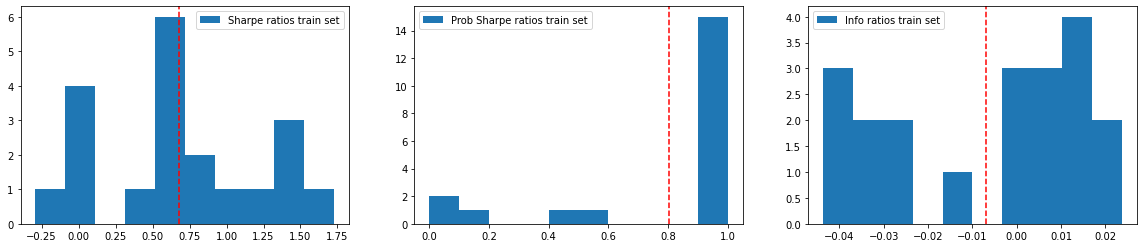

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4))
ax1.hist(sharpes_train, label = 'Sharpe ratios train set')
ax1.axvline(np.mean(sharpes_train), ls = '--', color = 'red')
ax2.hist(prob_sharpes_train, label = 'Prob Sharpe ratios train set')
ax2.axvline(np.mean(prob_sharpes_train), ls = '--', color = 'red')
ax3.hist(info_ratios_train, label = 'Info ratios train set')
ax3.axvline(np.mean(info_ratios_train), ls = '--', color = 'red')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

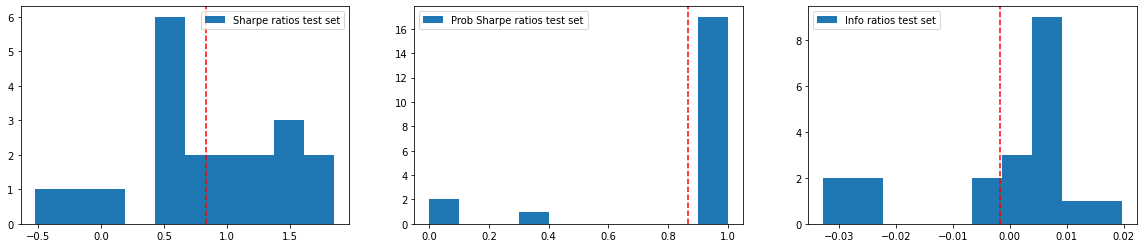

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4))
ax1.hist(sharpes_test, label = 'Sharpe ratios test set')
ax1.axvline(np.mean(sharpes_test), ls = '--', color = 'red')
ax2.hist(prob_sharpes_test, label = 'Prob Sharpe ratios test set')
ax2.axvline(np.mean(prob_sharpes_test), ls = '--', color = 'red')
ax3.hist(info_ratios_test, label = 'Info ratios test set')
ax3.axvline(np.mean(info_ratios_test), ls = '--', color = 'red')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Backtest overfitting

In [39]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
Y = sharpes_test
X = sharpes_train
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [41]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.909
Date:                Mon, 07 Jun 2021   Prob (F-statistic):             0.0398
Time:                        20:48:28   Log-Likelihood:                -16.232
No. Observations:                  20   AIC:                             36.46
Df Residuals:                      18   BIC:                             38.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4872      0.202      2.408      0.0

In [42]:
results.params

array([0.48716642, 0.50832994])

In [43]:
x = np.arange(np.min(sharpes_train), np.max(sharpes_train), 0.1)
y = results.params[0] + results.params[1] * x

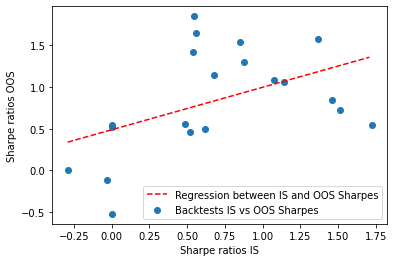

In [44]:
plt.figure()
plt.scatter(sharpes_train, sharpes_test, label = 'Backtests IS vs OOS Sharpes')
plt.plot(x, y, color = 'red', ls = '--', label = 'Regression between IS and OOS Sharpes')
plt.xlabel('Sharpe ratios IS')
plt.ylabel('Sharpe ratios OOS')
plt.legend()
plt.show()

# Strategy Risk

In [45]:
def binHR(sl, pt, n, tSR):
    a = (n + tSR**2) * (pt - sl)**2
    b = (2*n*sl - tSR**2*(pt-sl))*(pt-sl)
    c = n*sl**2
    p = (-b + (b**2 - 4*a*c)**0.5) / (2.*a)
    return p

def probFailure(ret, freq, tSR):
    # Derive probability that strategy may fail
    rPos, rNeg = ret[ret>0].mean(), ret[ret<=0].mean()
    p = ret[ret>0].shape[0] / float(ret.shape[0])
    thresP = binHR(rNeg, rPos, freq, tSR)
    risk = scipy_stats.norm.cdf(thresP, p, p*(1-p)) # approximation to bootstrap
    return risk

In [46]:
test_returns_all = [
         pd.DataFrame(v['history']['net_worth']).pct_change().fillna(0.0).values for v in test_results.values()
              ]

In [47]:
failure_probs = []
for test_return in test_returns_all:
    pf = probFailure(test_return, 252, 0.0)
    failure_probs.append(pf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


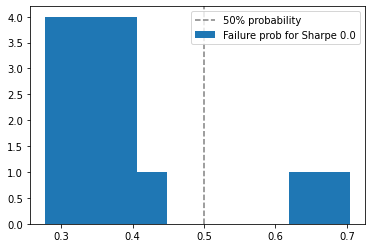

In [48]:
plt.figure()
plt.hist(failure_probs, label = 'Failure prob for Sharpe 0.0')
plt.axvline(0.5, ls = '--', color = 'grey', label = '50% probability')
plt.legend()
plt.show()

# Multiple testing

In [49]:
N_TIME_STEPS2 = N_TIME_STEPS / 2

In [50]:
test_nws = []
for n in tqdm.tqdm(range(20)):
    env_train = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
    env_test = DummyVecEnv([lambda: StockTradingEnv(df_test, INIT_NET_WORTH, WINDOW)])
    model_i = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR)
    model_i.learn(total_timesteps=N_TIME_STEPS2)
    history_test, actions_over_time_test = evaluate_agent(env_test, df_test, model_i)
    test_nws.append(history_test['net_worth'])

  0%|          | 0/20 [00:00<?, ?it/s]

Using cuda device


  5%|▌         | 1/20 [00:06<02:07,  6.72s/it]

Using cuda device


 10%|█         | 2/20 [00:13<02:00,  6.68s/it]

Using cuda device


 15%|█▌        | 3/20 [00:19<01:52,  6.65s/it]

Using cuda device


 20%|██        | 4/20 [00:26<01:46,  6.63s/it]

Using cuda device


 25%|██▌       | 5/20 [00:32<01:38,  6.59s/it]

Using cuda device


 30%|███       | 6/20 [00:39<01:31,  6.56s/it]

Using cuda device


 35%|███▌      | 7/20 [00:45<01:25,  6.55s/it]

Using cuda device


 40%|████      | 8/20 [00:52<01:18,  6.55s/it]

Using cuda device


 45%|████▌     | 9/20 [00:59<01:12,  6.55s/it]

Using cuda device


 50%|█████     | 10/20 [01:05<01:05,  6.54s/it]

Using cuda device


 55%|█████▌    | 11/20 [01:12<00:58,  6.54s/it]

Using cuda device


 60%|██████    | 12/20 [01:18<00:52,  6.55s/it]

Using cuda device


 65%|██████▌   | 13/20 [01:25<00:45,  6.56s/it]

Using cuda device


 70%|███████   | 14/20 [01:31<00:39,  6.55s/it]

Using cuda device


 75%|███████▌  | 15/20 [01:38<00:32,  6.54s/it]

Using cuda device


 80%|████████  | 16/20 [01:44<00:26,  6.55s/it]

Using cuda device


 85%|████████▌ | 17/20 [01:51<00:19,  6.54s/it]

Using cuda device


 90%|█████████ | 18/20 [01:57<00:13,  6.54s/it]

Using cuda device


 95%|█████████▌| 19/20 [02:04<00:06,  6.53s/it]

Using cuda device


100%|██████████| 20/20 [02:11<00:00,  6.55s/it]


In [51]:
test_returns = pd.DataFrame(test_nws).T.pct_change().fillna(0.0)
te_sharpes = test_returns.mean() / test_returns.std()

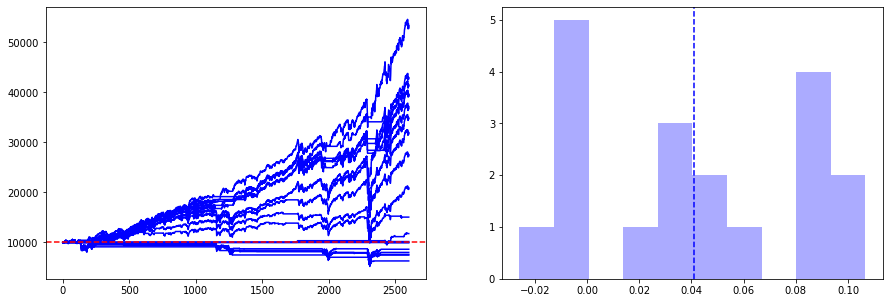

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for nwtest in test_nws:
    ax1.plot(nwtest, color = 'blue')
ax1.axhline(INIT_NET_WORTH, ls = '--', color = 'red')
ax2.hist(te_sharpes, color = 'blue', alpha = 0.33)
ax2.axvline(te_sharpes.mean(), ls = '--', color = 'blue')
plt.show()

In [53]:
def num_independent_trials(trials_returns):
    m = trials_returns.shape[1]
    corr_matrix = trials_returns.corr().fillna(0.0)
    p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
    n = p + (1 - p) * m
    n = int(n)  # round up
    return n

def expected_maximum_sr(trials_returns, expected_mean_sr=0.0):
    emc = 0.5772156649 # Euler-Mascheroni constant
    independent_trials = num_independent_trials(trials_returns)
    srs = estimated_sharpe_ratio(trials_returns)
    trials_sr_std = srs.std()
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    return expected_max_sr

def deflated_sharpe_ratio(trials_returns, returns_selected, expected_mean_sr=0.0):
    expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)  
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)
    return dsr

In [54]:
best_test_index = (test_returns.mean(axis=0) / test_returns.std(axis=0)).fillna(0.0).sort_values()[::-1].index[0]
best_test = test_returns[best_test_index]

In [55]:
deflated_sharpe_ratio(test_returns, best_test)

0.9472890340187428

# Multiple testing #2

In [56]:
test_nws2 = []
for n in tqdm.tqdm(range(20)):
    env_train = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
    env_test = DummyVecEnv([lambda: StockTradingEnv(df_test, INIT_NET_WORTH, WINDOW)])
    model_i = PPO('MlpPolicy', env_train, verbose=1, learning_rate=LR)
    model_i.learn(total_timesteps=N_TIME_STEPS2)
    history_test, actions_over_time_test = evaluate_agent(env_test, df_test, model_i)
    test_nws2.append(history_test['net_worth'])

  0%|          | 0/20 [00:00<?, ?it/s]

Using cuda device


  5%|▌         | 1/20 [00:07<02:25,  7.67s/it]

Using cuda device


 10%|█         | 2/20 [00:15<02:18,  7.67s/it]

Using cuda device


 15%|█▌        | 3/20 [00:23<02:10,  7.67s/it]

Using cuda device


 20%|██        | 4/20 [00:30<02:02,  7.68s/it]

Using cuda device


 25%|██▌       | 5/20 [00:38<01:55,  7.68s/it]

Using cuda device


 30%|███       | 6/20 [00:46<01:47,  7.68s/it]

Using cuda device


 35%|███▌      | 7/20 [00:53<01:39,  7.68s/it]

Using cuda device


 40%|████      | 8/20 [01:01<01:31,  7.65s/it]

Using cuda device


 45%|████▌     | 9/20 [01:08<01:24,  7.64s/it]

Using cuda device


 50%|█████     | 10/20 [01:16<01:16,  7.65s/it]

Using cuda device


 55%|█████▌    | 11/20 [01:24<01:08,  7.67s/it]

Using cuda device


 60%|██████    | 12/20 [01:32<01:01,  7.70s/it]

Using cuda device


 65%|██████▌   | 13/20 [01:39<00:53,  7.69s/it]

Using cuda device


 70%|███████   | 14/20 [01:47<00:46,  7.68s/it]

Using cuda device


 75%|███████▌  | 15/20 [01:55<00:38,  7.71s/it]

Using cuda device


 80%|████████  | 16/20 [02:02<00:30,  7.70s/it]

Using cuda device


 85%|████████▌ | 17/20 [02:10<00:23,  7.68s/it]

Using cuda device


 90%|█████████ | 18/20 [02:18<00:15,  7.69s/it]

Using cuda device


 95%|█████████▌| 19/20 [02:25<00:07,  7.68s/it]

Using cuda device


100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


In [57]:
test_returns2 = pd.DataFrame(test_nws2).T.pct_change().fillna(0.0)
te_sharpes2 = test_returns2.mean() / test_returns2.std()

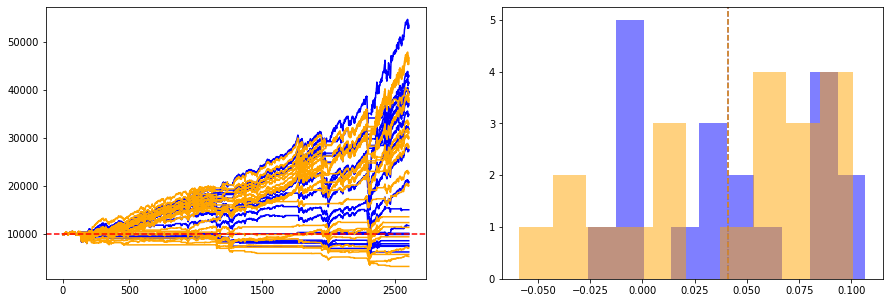

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for nwtest in test_nws:
    ax1.plot(nwtest, color = 'blue')
for nwtest in test_nws2:
    ax1.plot(nwtest, color = 'orange')
ax1.axhline(INIT_NET_WORTH, ls = '--', color = 'red')

ax2.hist(te_sharpes, color = 'blue', alpha = 0.5)
ax2.hist(te_sharpes2, color = 'orange', alpha = 0.5)
ax2.axvline(te_sharpes.mean(), ls = '--', color = 'blue')
ax2.axvline(te_sharpes2.mean(), ls = '--', color = 'orange')
plt.show()

In [59]:
import scipy.stats as stats

In [60]:
def welch_test(data1, data2, alpha=0.05, tail=2):
    t, p = stats.ttest_ind(data1, data2, equal_var=False)
    if tail==1:
        alpha = 2*alpha
    if p <= alpha:
        if t<0:
            print("Result of the Welch's t-test at level %02g: μ2>μ1, the test passed with p-value = %02g." %(alpha, p))
        else:
            print("Result of the Welch's t-test level %02g: μ1>μ2, the test passed with p-value = %02g." %(alpha, p))
    else:
        print("Results of the Welch's t-test level %02g: there is not enough evidence to prove any order relation between μ1 and μ2." % alpha)
    print("Welch's t-test done.", t, p)

In [61]:
welch_test(te_sharpes.dropna(), te_sharpes2.dropna())

Results of the Welch's t-test level 0.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Welch's t-test done. 0.00487622418657937 0.996135653555424
